# Initial Exploration of the Metadata

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from pathlib import Path
from PIL import Image
from src.visualization.exploration import *

In [4]:
train = pd.read_csv("../data/internal/train.csv")
test = pd.read_csv("../data/internal/test.csv")
train_ext = pd.read_csv("../data/external/train.csv")

In [5]:
train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height'],
      dtype='object')

In [6]:
train.describe()

,age_approx,target,tfrecord,width,height
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256
std,14.380360,0.131603,4.390486,2109.145590,1437.617626
min,0.000000,0.000000,-1.000000,640.000000,480.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


We can see there are null values in *sex*, *age_approx* and *anatom_site_general_challenge* which will need to be dealth with before taining.

In [8]:
train.nunique()

image_name                       33126
patient_id                        2056
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
tfrecord                            16
width                               87
height                              86
dtype: int64

The fact that there are fewer patient_ids than images indicates that there are multiple images in the dataset of the same patient. This has important consequences for model selection, as if we include the same patient in both training and validation data our model is able to exploit the similar image. This will lead to an artificially high validation error and we will see lower performance on the test set which does not contain the same patient.

<AxesSubplot:xlabel='sex', ylabel='count'>

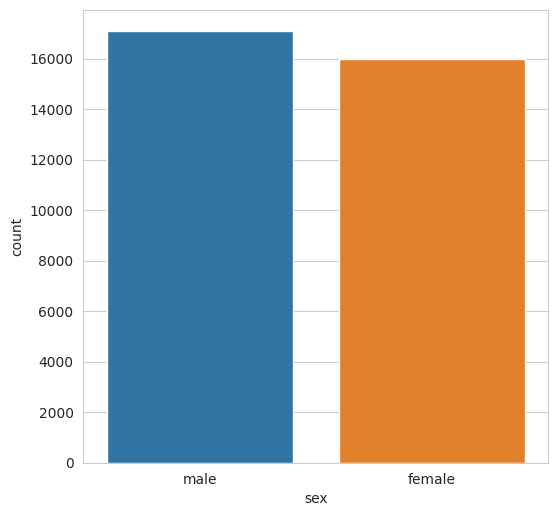

In [9]:
fig_sex, ax_sex = plt.subplots(figsize=(6, 6), dpi=100)
sns.countplot(x='sex', data=train, ax=ax_sex)

This plot indicates that there are slightly more males in the training data than females.

<AxesSubplot:xlabel='sex', ylabel='count'>

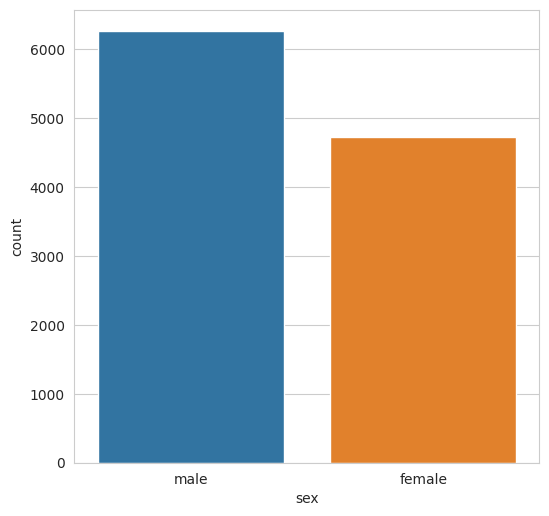

In [10]:
fig_sex2, ax_sex2 = plt.subplots(figsize=(6, 6), dpi=100)
sns.countplot(x='sex', data=test, ax=ax_sex2)

It appears that there may be a higher proportion of males in the test data than in the training data. But let's check numerically as it could just be the scale of the plot.

In [11]:
(train['sex'] == 'male').sum() / len(train)

0.5156070760127996

In [12]:
(test['sex'] == 'male').sum() / len(test)

0.5695683846293935

It is true that is a higher proportion of males in the test data than in the training. The training is 51.6% male whereas the test data is 57.0% male.

<AxesSubplot:xlabel='age_approx', ylabel='count'>

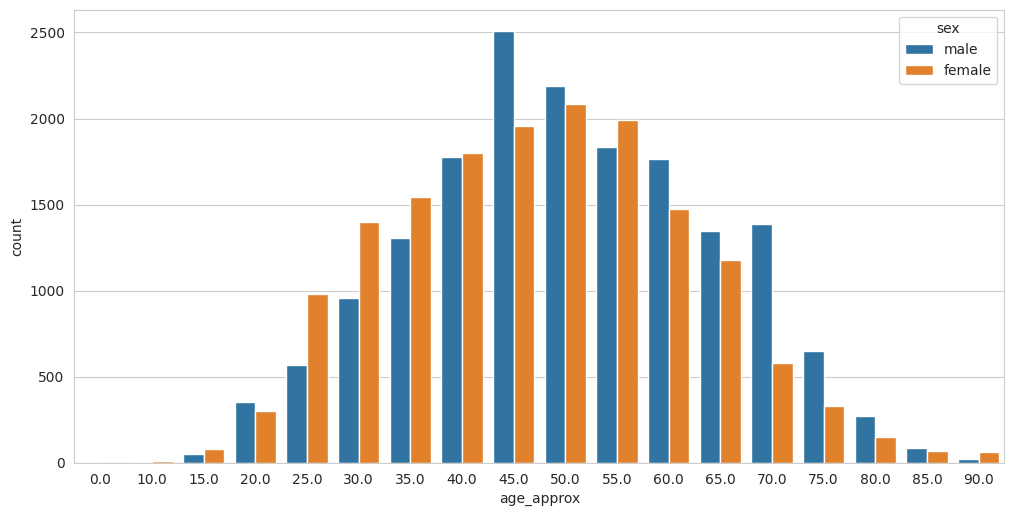

In [13]:
fig_agesex, ax_agesex = plt.subplots(figsize=(12, 6), dpi=100)
sns.countplot(x='age_approx', data=train, ax=ax_agesex, hue='sex')

We see an interesting trend that around the ages of 25 to 40 there are more females in the dataset and for older patients there are more males (exceptions: 55, 90). If I had to hypothesis why this is the case, maybe it's because women from the age of 25 to 40 are seeing a doctor (their gynocologist) semi-regularly, who may tell them to see a dermatologist if they see a lesion, whereas many 25-40 year olds males never see any doctor. However, I am not a health professional so this may be incorrect.

<AxesSubplot:xlabel='anatom_site_general_challenge', ylabel='count'>

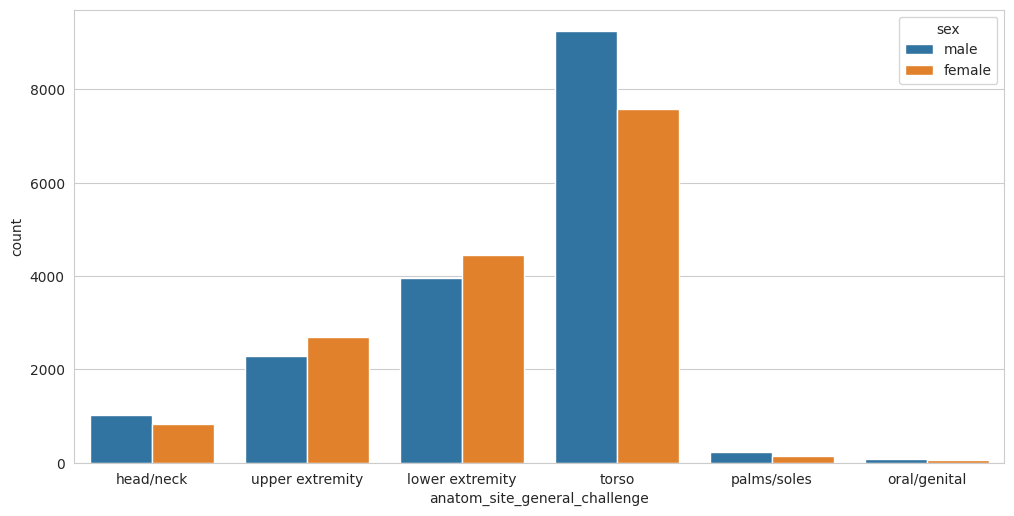

In [14]:
fig_anasex, ax_anasex = plt.subplots(figsize=(12, 6), dpi=100)
sns.countplot(x='anatom_site_general_challenge', data=train, ax=ax_anasex, hue='sex')

It is interesting to note that despite males outnumbering females in the data, for the anatomical sites *upper extremity* and *lower extremity* females outnumber males.

<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

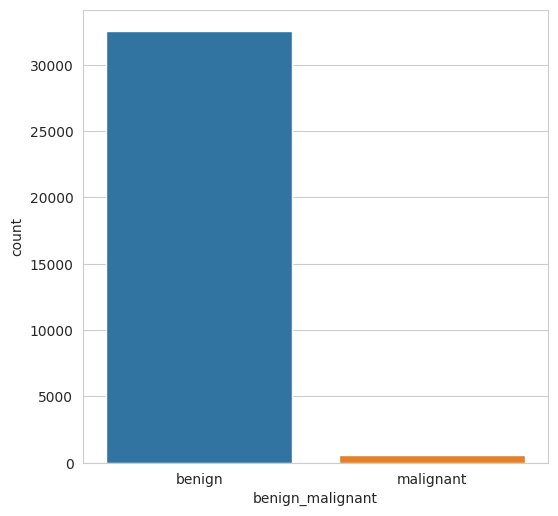

In [15]:
fig_bm, ax_bm = plt.subplots(figsize=(6, 6), dpi=100)
sns.countplot(x='benign_malignant', data=train, ax=ax_bm)

In [16]:
(train['benign_malignant'] == 'malignant').sum() / len(train)

0.01762965646320111

The graph and value above demonstrate the imbalance in the target variable. This is a common problem (in the machine learning sense, not medical) where the value we are trying to predict has a much higher proportion of one class than the other. In this data, only 1.76% represent malignant cases which is of course a good thing but this makes a model more difficult to train.

<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

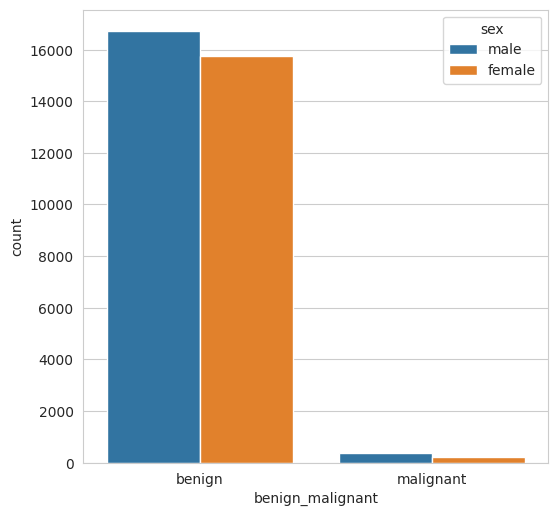

In [17]:
fig4, ax4 = plt.subplots(figsize=(6, 6), dpi=100)
sns.countplot(x='benign_malignant', data=train, ax=ax4, hue='sex')

In [18]:
((train['benign_malignant'] == 'malignant') & (train['sex'] == 'male')).sum() / (train['sex'] == 'male').sum()

0.021311475409836064

In [19]:
((train['benign_malignant'] == 'malignant') & (train['sex'] == 'female')).sum() / (train['sex'] == 'female').sum()

0.01376634753770102

The plot and values above show that a higher proportion of males have malignant lesions compared to females. This appears to be true as a general rule in the population after reading a few medical references on the [web](https://www.cancer.org/cancer/melanoma-skin-cancer/about/key-statistics.html). Although it could be that more melanomas are diagnosed in men compared to women rather than men being more likely to have melanomas.

<AxesSubplot:xlabel='age_approx', ylabel='count'>

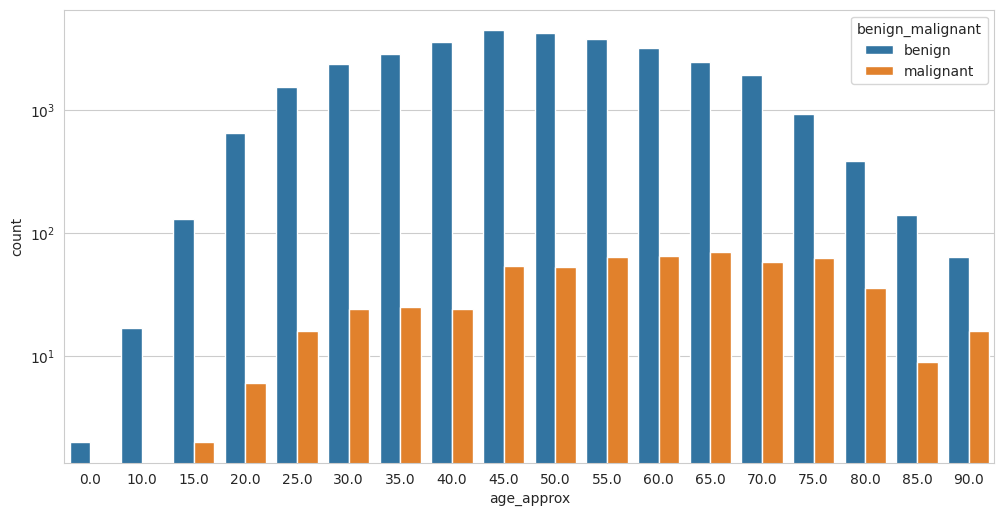

In [20]:
fig5, ax5 = plt.subplots(figsize=(12, 6), dpi=100)
ax5.set_yscale('log')
sns.countplot(x='age_approx', data=train, ax=ax5, hue='benign_malignant')

This plot shows that as patients get older, a higher proportion of them have malignant lesions as opposed to benign. This means that age could be a good predictor for the target variable.

<AxesSubplot:xlabel='anatom_site_general_challenge', ylabel='count'>

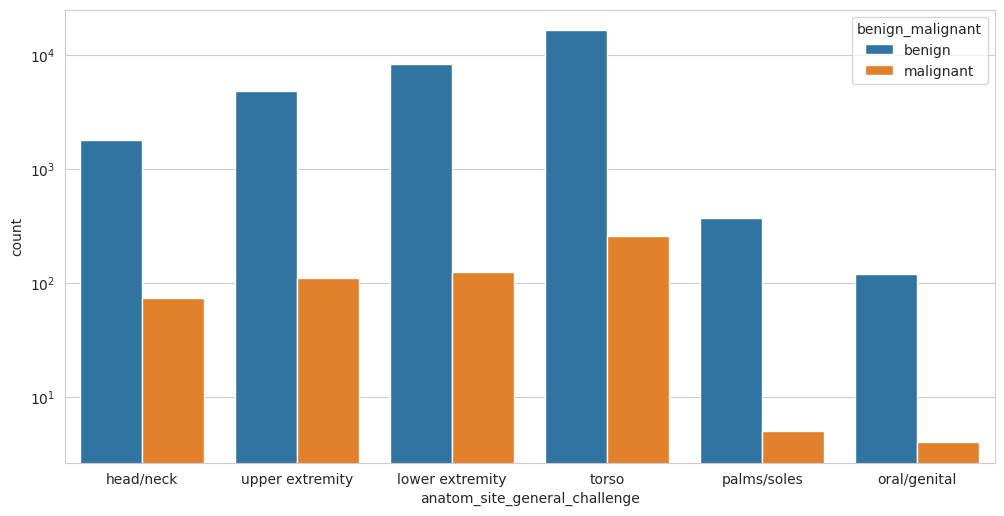

In [21]:
fig6, ax6 = plt.subplots(figsize=(12, 6), dpi=100)
ax6.set_yscale('log')
sns.countplot(x='anatom_site_general_challenge', data=train, ax=ax6, hue='benign_malignant')

This plot shows the proportion of malignant lesions for each of the anatomical areas. The low proportion for *palms/soles* and *oral/genital* makes sense as these areas are typically not exposed to direct sunlight.

Finally, let's take a look at a few of the images. I am not a dermatologist or medical professional but maybe we can discern some characteristics of malignant melanoma.

In [22]:
benign_sample = train[train['benign_malignant'] == 'benign'].sample(20, random_state=42).reset_index()
malignant_sample = train[train['benign_malignant'] == 'malignant'].sample(20, random_state=42).reset_index()

In [23]:
benign_sample

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,30065,ISIC_9085719,IP_3562983,male,35.0,torso,unknown,benign,0,6,6000,4000
1,12966,ISIC_3990124,IP_9909432,male,35.0,torso,unknown,benign,0,8,640,480
2,16757,ISIC_5125438,IP_1139701,female,45.0,torso,unknown,benign,0,13,6000,4000
3,9914,ISIC_3076237,IP_9802994,female,40.0,torso,unknown,benign,0,3,6000,4000
4,17057,ISIC_5209007,IP_1051664,male,35.0,lower extremity,nevus,benign,0,5,1872,1053
5,31199,ISIC_9430349,IP_4898383,male,30.0,torso,unknown,benign,0,4,6000,4000
6,4715,ISIC_1511913,IP_0963996,female,40.0,torso,unknown,benign,0,2,6000,4000
7,1543,ISIC_0565046,IP_3397861,female,65.0,torso,nevus,benign,0,4,6000,4000
8,26607,ISIC_8065339,IP_9373614,female,50.0,torso,nevus,benign,0,5,1872,1053
9,16452,ISIC_5036393,IP_4169963,female,55.0,torso,unknown,benign,0,2,5184,3456


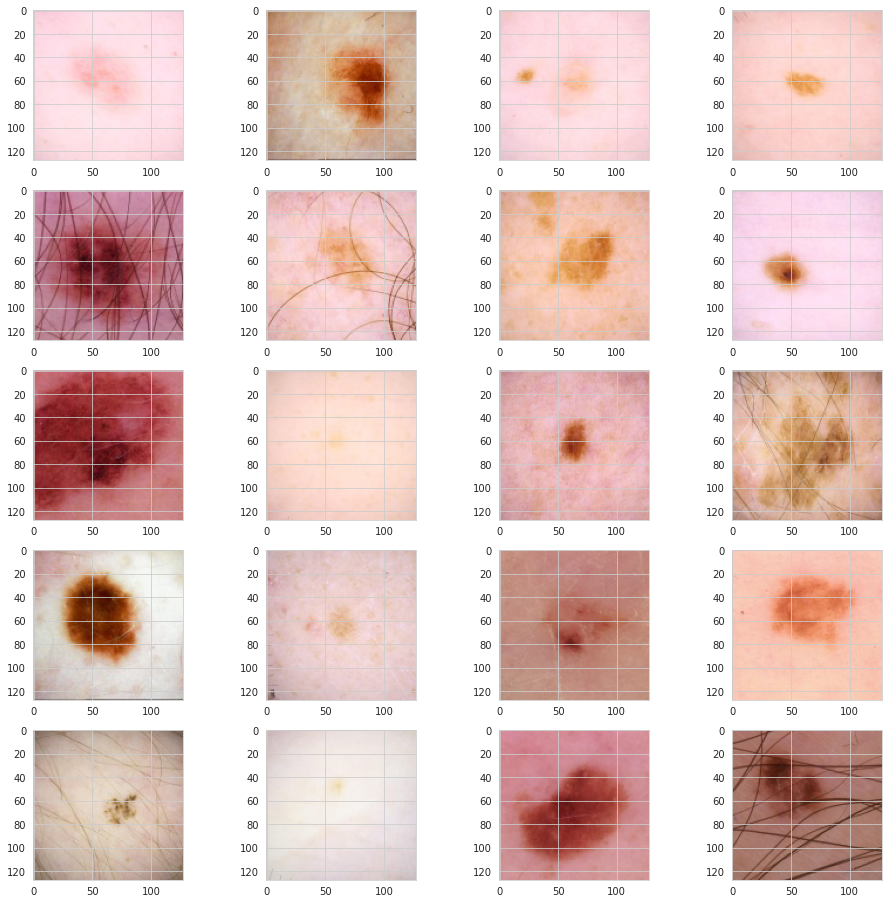

In [31]:
grid_show(benign_sample, "../data/internal/train", 16, 16, 4, 5)

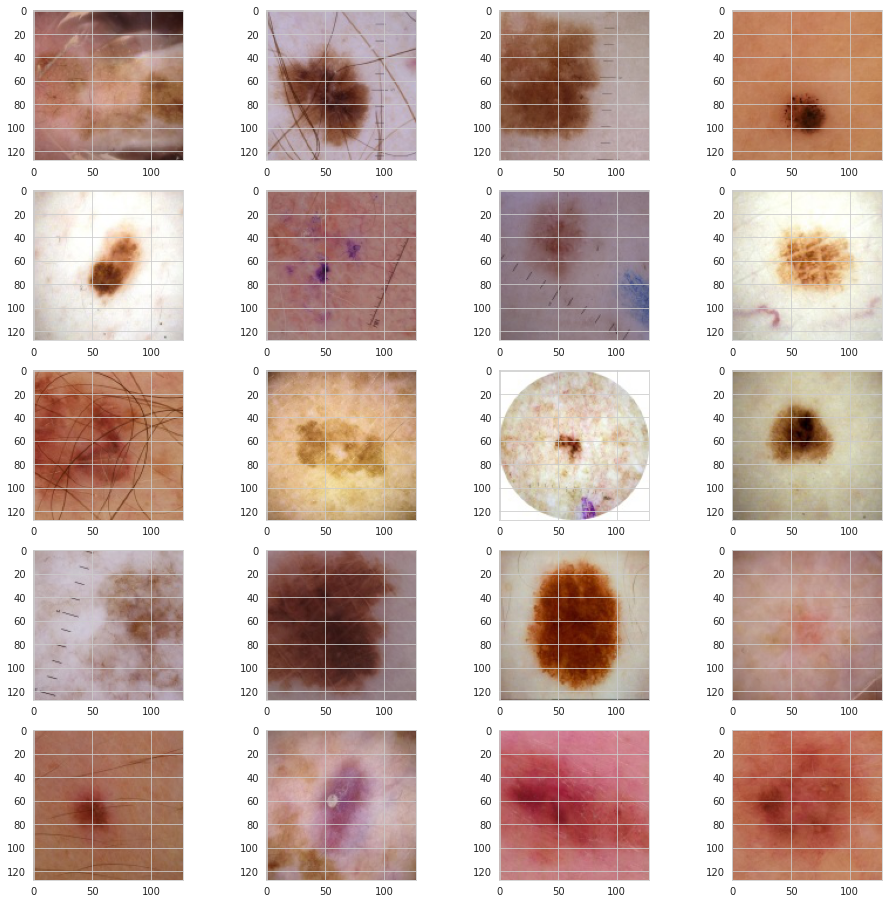

In [32]:
grid_show(malignant_sample, "../data/internal/train", 16, 16, 4, 5)

A quick cursory analysis of the images suggests that malignant lesions may be darker in color and contain more irregular shapes. We also notice blue coloring which may be a pen used by a doctor or the skin. This odd coloring may become a key feature in the deep learning model.

Now let's pick a patient who has multiple images in the dataset and show them.

In [56]:
train['patient_id'].value_counts(sort=True)

IP_7279968    115
IP_4938382    115
IP_4382720    115
IP_4479736    115
IP_0656529    114
             ... 
IP_9328721      3
IP_1627142      3
IP_1330994      3
IP_4956722      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [47]:
patient = train[train['patient_id'] == 'IP_7279968']
patient

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
15,ISIC_0078703,IP_7279968,male,45.0,torso,unknown,benign,0,0,6000,4000
47,ISIC_0092726,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
201,ISIC_0179056,IP_7279968,male,45.0,torso,unknown,benign,0,0,6000,4000
382,ISIC_0229459,IP_7279968,male,45.0,torso,unknown,benign,0,0,6000,4000
...,...,...,...,...,...,...,...,...,...,...,...
31544,ISIC_9534415,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
31816,ISIC_9615629,IP_7279968,male,45.0,upper extremity,unknown,benign,0,0,6000,4000
32023,ISIC_9672879,IP_7279968,male,45.0,upper extremity,unknown,benign,0,0,6000,4000
32031,ISIC_9676432,IP_7279968,male,45.0,torso,unknown,benign,0,0,6000,4000


As can be seen above, thankfully this patient does not have malignant lesions. Let's see if the images are duplicates.

In [50]:
patient_sample = train[train['patient_id'] == 'IP_7279968'].sample(20, random_state=42).reset_index()

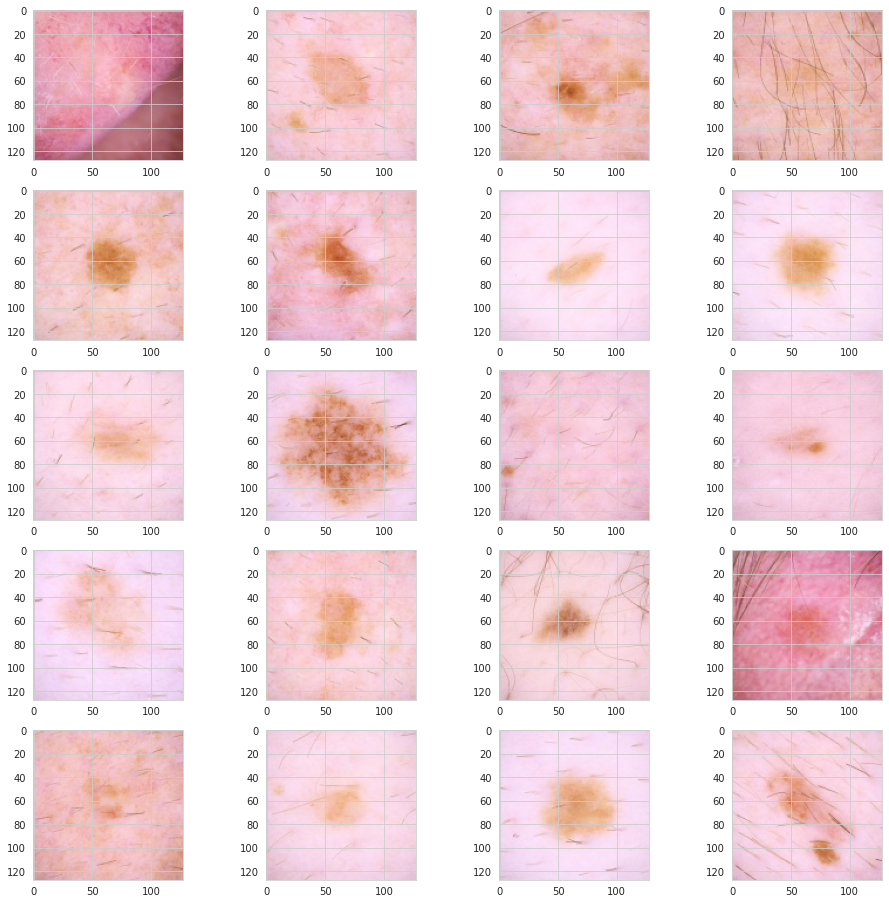

In [51]:
grid_show(patient_sample, "../data/internal/train", 16, 16, 4, 5)

The images are not duplicates (the organisors tried to remove all) so this patient just has multiple lesions on their body checked and thankfully they were all benign.

Let's try to find a patient with multiple images who has malignant lesions.

In [59]:
duplicates = train[train.duplicated(subset='patient_id')]
duplicates[duplicates['target'] == 1]['patient_id'].value_counts()

IP_7373371    8
IP_9111321    6
IP_3237442    4
IP_2412574    4
IP_9086201    4
             ..
IP_4116267    1
IP_8412988    1
IP_4762742    1
IP_6151980    1
IP_0825081    1
Name: patient_id, Length: 389, dtype: int64

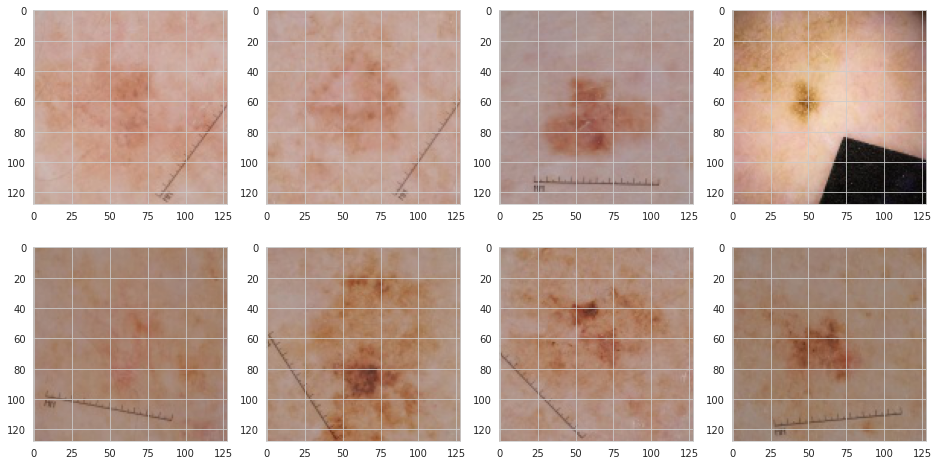

In [64]:
malignant_patient_sample = train[(train['patient_id'] == 'IP_7373371') & (train['benign_malignant'] == 'malignant')].sample(8, random_state=42).reset_index()
grid_show(malignant_patient_sample, "../data/internal/train", 16, 8, 4, 2)